In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
import scipy.optimize as optimize

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [66]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [67]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']*0.1
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [68]:
target_columns = ['S000']
for city, state, conties in cities:
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
    training_set.to_csv('cities/%s.csv'%city,index=False)
#     break

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


# baseline

### unconstrain model, power law

In [37]:

def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

def power_law_no_k(x,a):
    return (x[:,0]**a)*x[:,1]*x[:,2]
def baseline_nok_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_nok_predict(test,target,pars):
    test[target+'a'] = pars[0]
    test[target+'pred'] = (test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test


# bucked unconstrained power law with distance

In [38]:


def power_law_k(x,a):
    return (x[:,0]**a)*x[:,1]*x[:,2]*x[:,3]

def fit_dist(data,target,k):
    data['k'] = k
    X = data[['distance', target+'jobs', target+'residence','k']].values
    y = data[target+'flow'].values
    pars, cov = optimize.curve_fit(f=power_law_k, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
    return k,pars[0]

def fit_piece_power_law(data,target,k):
    bins_list = data['bin'].unique()    
    bin_to_model = {}
    for b in bins_list:
        subData = data[data['bin'] == b]
        model = fit_dist(subData,target,k)
        k = model[0]
        bin_to_model[b] = model[1]
        
    return (k,bin_to_model)

def predict_piece_powerlaw(data,target,model):
    k = model[0]
    bin_to_model =  model[1]
    data[target+'a'] = data['bin'].apply(lambda x:bin_to_model[x]).astype(float)
    data[target+'pred'] = (data['distance']**data[target+'a'])*data[target+'jobs']*data[target+'residence']*k
    return data

# bucked gravity model

In [39]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def bucked_power_law(x,f):
    return f*(x[:,0]*x[:,1]*x[:,2])
def unconstrained_bucked_constant_fit(data, target):
    binf = {}
    X = data[[target+'jobs',target+'residence']].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    data[target+'k'] = results.params[0]
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return (results.params[0],binf)
def unconstrained_bucked_constant_predict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

In [40]:
def unconstrained_bucked_constant_kfit(data, target,k):
    binf = {}
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return binf
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

In [41]:
def unconstrained_bucked_nok_constant_fit(data, target):
    binf = {}
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return binf
def unconstrained_bucked_nok_constant_predict(test,target,binf):
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

In [43]:
def datacut(df,bins,bintarget):
    df['bin'] = pd.cut(np.log(df['distance']), bins=bins)
    if len(df.bin.unique())!=bintarget:
        bins = bins+1
        print('empty bin exist, increase bins')
        return datacut(df,bins,bintarget)
    else:
        return df

In [ ]:
# with k, two-step k for f(d)
mseDict = {}
binfDict = {}
OSDict = {}
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
kfold = 5
for city in cities:
    if '.csv' in city:
        mseBaseline,msefd = [],[]
        baselineoutput = pd.DataFrame()
        fdoutput = pd.DataFrame()
        print(city)
        df = pd.read_csv(citiesDir+city)
        df = datacut(df,20,20)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = df['bin'].astype(str)
        
        skf = StratifiedKFold(n_splits=kfold)
        X = df[['origin', 'destination', 'distance', target+'residence',
           target+'jobs', target+'flow']].values
        y = df[['bin']].values
        skf.get_n_splits(X,y)
        binfdf = pd.DataFrame()
        for train_index, test_index in skf.split(X, y):
            train_set, test_set = df.loc[train_index], df.loc[test_index]
        
        
            #baseline
            pars = baseline_fit(train_set,target)
            k = pars[0]
            test_baseline = baseline_predict(test_set,target,pars)
            mseBaseline += [mean_squared_error(test_baseline[target+'flow'],test_baseline[target+'pred'])]
            baselineoutput = pd.concat([baselineoutput,test_baseline])
            # fd
            k,binf = unconstrained_bucked_constant_fit(train_set, target)
            test_fd = unconstrained_bucked_constant_predict(test_set,target,k,binf)
            msefd += [mean_squared_error(test_fd[target+'flow'],test_fd[target+'pred'])]
            fdoutput = pd.concat([fdoutput,test_fd])
            
            binfdftemp = pd.DataFrame({'bin':binf.keys(),'f(d)':binf.values()})
            binfdf = pd.concat([binfdftemp,binfdf])
        binfdf = binfdf.groupby(['bin']).mean()
        mseDict[city] = [np.mean(mseBaseline),np.mean(msefd)]
        binfDict[city] = binfdf
        OSDict[city] = [baselineoutput,fdoutput]

In [357]:
results = pd.DataFrame.from_dict(mseDict).T
results.columns = ['baseline','f(d)']
results.dropna()

,baseline,f(d)
Chicago.csv,28.657597,452.453508
Phoenix.csv,19.234402,394.549271
New York City.csv,4.783870,1223.938098
San Diego.csv,57.934043,489.599453
San Jose.csv,71.244477,845.853981
Austin.csv,158.872611,192.812439
San Antonio.csv,47.032220,255.466379
Philadelphia.csv,26.778514,108.776697
Dallas.csv,33.997703,735.499619
Houston.csv,46.198151,493.511555


In [84]:
def findBestBin(df,bins=20):
    mseBaseline,msefd = [],[]
    df = datacut(df,bins,bins)
    df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df['bin'] = df['bin'].astype(str)

    skf = StratifiedKFold(n_splits=5)
    X = df[['origin', 'destination', 'distance', target+'residence',
       target+'jobs', target+'flow']].values
    y = df[['bin']].values
    skf.get_n_splits(X,y)
    binfdf = pd.DataFrame()
    for train_index, test_index in skf.split(X, y):
        train_set, test_set = df.loc[train_index], df.loc[test_index]


        #baseline
        pars = baseline_fit(train_set,target)
        k = pars[0]
        test_baseline = baseline_predict(test_set,target,pars)
        mseBaseline += [mean_squared_error(test_baseline[target+'flow'],test_baseline[target+'pred'])]

        # fd
        binf = unconstrained_bucked_constant_kfit(train_set, target,k)
        test_fd = unconstrained_bucked_constant_predict(test_set,target,k,binf)
        msefd += [mean_squared_error(test_fd[target+'flow'],test_fd[target+'pred'])]
#         fdoutput = pd.concat([fdoutput,test_fd])
        binfdftemp = pd.DataFrame({'bin':binf.keys(),'f(d)':binf.values()})
        binfdf = pd.concat([binfdftemp,binfdf])
    if np.mean(msefd)<np.mean(mseBaseline):
        return (bins,binfdf,np.mean(mseBaseline),np.mean(msefd))
    else:
        bins = bins+5
        print(bins)
        return findBestBin(df,bins)

In [85]:
mseDict = {}
binfDict = {}
# OSDict = {}
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
kfold = 5
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)
        bins,binfdf,mseBaseline,msefd = findBestBin(df,10)
        binfdf = binfdf.groupby(['bin']).mean()
        mseDict[city] = [np.mean(mseBaseline),np.mean(msefd)]
        binfDict[city] = binfdf
#         OSDict[city] = [baselineoutput,fdoutput]

Chicago.csv
15
Phoenix.csv
15
New York City.csv
15
20
25
30
35
40
45
50
55
60
65


KeyboardInterrupt: 

In [69]:
# same k for both
mseDict = {}
binfDict = {}
OSDict = {}
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
kfold = 5
for city in cities:
    if '.csv' in city:
        mseBaseline,msefd = [],[]
        baselineoutput = pd.DataFrame()
        fdoutput = pd.DataFrame()
        print(city)
        df = pd.read_csv(citiesDir+city)
        df = datacut(df,30,30)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = df['bin'].astype(str)
        
        skf = StratifiedKFold(n_splits=kfold)
        X = df[['origin', 'destination', 'distance', target+'residence',
           target+'jobs', target+'flow']].values
        y = df[['bin']].values
        skf.get_n_splits(X,y)
        binfdf = pd.DataFrame()
        for train_index, test_index in skf.split(X, y):
            train_set, test_set = df.loc[train_index], df.loc[test_index]
        
        
            #baseline
            pars = baseline_fit(train_set,target)
            k = pars[0]
            test_baseline = baseline_predict(test_set,target,pars)
            mseBaseline += [mean_squared_error(test_baseline[target+'flow'],test_baseline[target+'pred'])]
            baselineoutput = pd.concat([baselineoutput,test_baseline])
            # fd
            binf = unconstrained_bucked_constant_kfit(train_set, target,k)
            test_fd = unconstrained_bucked_constant_predict(test_set,target,k,binf)
            msefd += [mean_squared_error(test_fd[target+'flow'],test_fd[target+'pred'])]
            fdoutput = pd.concat([fdoutput,test_fd])
            
            binfdftemp = pd.DataFrame({'bin':binf.keys(),'f(d)':binf.values()})
            binfdf = pd.concat([binfdftemp,binfdf])
        binfdf = binfdf.groupby(['bin']).mean()
        mseDict[city] = [np.mean(mseBaseline),np.mean(msefd)]
        binfDict[city] = binfdf
        OSDict[city] = [baselineoutput,fdoutput]

Chicago.csv
empty bin exist, increase bins
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [70]:
results = pd.DataFrame.from_dict(mseDict).T
results.columns = ['baseline','f(d)']
results.dropna()

,baseline,f(d)
Chicago.csv,17.771868,16.651638
Phoenix.csv,16.390060,14.925891
New York City.csv,4.435548,4.749659
San Diego.csv,45.659719,45.213839
San Jose.csv,55.474525,209.908914
Austin.csv,123.161438,109.188854
San Antonio.csv,42.308476,48.304990
Philadelphia.csv,21.299683,25.029150
Dallas.csv,27.227055,33.491987
Houston.csv,38.691292,37.720727


In [360]:
# no k experiment
mseDict = {}
binfDict = {}
OSDict = {}
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
kfold = 5
for city in cities:
    if '.csv' in city:
        mseBaseline,msefd = [],[]
        baselineoutput = pd.DataFrame()
        fdoutput = pd.DataFrame()
        print(city)
        df = pd.read_csv(citiesDir+city)
        df = datacut(df,20,20)
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = df['bin'].astype(str)
        
        skf = StratifiedKFold(n_splits=kfold)
        X = df[['origin', 'destination', 'distance', target+'residence',
           target+'jobs', target+'flow']].values
        y = df[['bin']].values
        skf.get_n_splits(X,y)
        binfdf = pd.DataFrame()
        for train_index, test_index in skf.split(X, y):
            train_set, test_set = df.loc[train_index], df.loc[test_index]
        
        
            #baseline
            pars = baseline_nok_fit(train_set,target)
            k = 1
            test_baseline = baseline_nok_predict(test_set,target,pars)
            mseBaseline += [mean_squared_error(test_baseline[target+'flow'],test_baseline[target+'pred'])]
            baselineoutput = pd.concat([baselineoutput,test_baseline])
            # fd
            binf = unconstrained_bucked_constant_kfit(train_set, target,k)
            test_fd = unconstrained_bucked_constant_kpredict(test_set,target,k,binf)
            msefd += [mean_squared_error(test_fd[target+'flow'],test_fd[target+'pred'])]
            fdoutput = pd.concat([fdoutput,test_fd])
            
            binfdftemp = pd.DataFrame({'bin':binf.keys(),'f(d)':binf.values()})
            binfdf = pd.concat([binfdftemp,binfdf])
        binfdf = binfdf.groupby(['bin']).mean()
        mseDict[city] = [np.mean(mseBaseline),np.mean(msefd)]
        binfDict[city] = binfdf
        OSDict[city] = [baselineoutput,fdoutput]

Chicago.csv
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
Phoenix.csv
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist

empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
Los Angeles.csv
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins
empty bin exist, increase bins


In [437]:
results = pd.DataFrame.from_dict(mseDict).T
results.columns = ['baseline','f(d)']
results.dropna()

,baseline,f(d)
Chicago.csv,19.151157,17.381456
Phoenix.csv,15.699078,15.603982
New York City.csv,4.404931,4.432391
San Diego.csv,45.934173,44.671612
San Jose.csv,57.961114,58.879035
Austin.csv,124.828823,127.892360
San Antonio.csv,41.192964,41.437421
Philadelphia.csv,20.526631,21.717870
Dallas.csv,28.886450,27.814432
Houston.csv,37.888249,36.466633


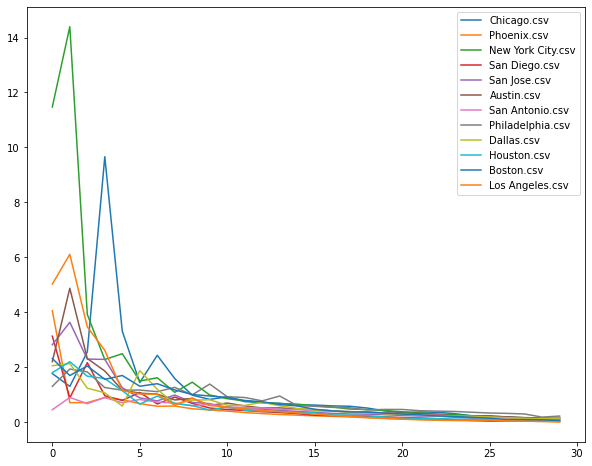

In [63]:
fig = plt.figure(figsize=(10,8))
for city in cities:
    if '.csv' in city:
        df = binfDict[city]
        df = df.reset_index()
        df['left'] = df['bin'].apply(lambda x: x.split(',')[0].split('(')[1]).astype(float)
        df = df.sort_values(by='left')
        plt.plot(range(30),df['f(d)'],label=city)
plt.legend()

# binwise MSE comparison

In [371]:

target= 'S000'
binwisemse = pd.DataFrame(index=range(20))
for city in cities:   
    if '.csv' in city:
        print(city)
        baselinemse = []
        fdmes = []
        baseline = OSDict[city][0]
        fd = OSDict[city][1]
        for i,bins in enumerate(sorted(baseline.bin.unique())):
            baselinemse += [mean_squared_error(baseline.loc[baseline['bin']==bins][target+'flow'],
                                               baseline.loc[baseline['bin']==bins][target+'pred'])]
            fdmes += [mean_squared_error(fd.loc[fd['bin']==bins][target+'flow'],
                                   fd.loc[fd['bin']==bins][target+'pred'])]
        binwisemse[city.split('.csv')[0]+'bl'] = baselinemse
        binwisemse[city.split('.csv')[0]+'fd'] = fdmes

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [372]:
binwisemse

,Chicagobl,Chicagofd,Phoenixbl,Phoenixfd,New York Citybl,New York Cityfd,San Diegobl,San Diegofd,San Josebl,San Josefd,...,Philadelphiabl,Philadelphiafd,Dallasbl,Dallasfd,Houstonbl,Houstonfd,Bostonbl,Bostonfd,Los Angelesbl,Los Angelesfd
0,514.237484,228.761030,117.312359,69.719690,109.555526,98.103693,279.002918,220.793613,258.996249,289.096265,...,522.074189,456.515919,166.193235,84.139228,329.005185,181.241170,524.366196,341.648275,105.831047,99.614851
1,221.750873,110.746483,33.444551,19.752498,265.543466,242.395765,292.933770,223.734613,105.326526,41.050003,...,111.197949,97.983014,235.300816,275.396626,66.003823,48.615081,1135.641363,889.126605,73.271222,88.193507
2,209.398644,207.905066,12.046334,0.271831,242.344782,224.382503,429.817055,3094.594009,14.682587,9.949713,...,83.498765,69.379662,60.958803,80.894893,76.204153,22.618637,537.577440,275.723143,53.390921,30.037131
3,55.338920,16.313961,2433.785320,2311.481753,147.272615,136.317949,303.145785,235.722738,4134.053955,332.776608,...,149.738820,68.147862,16.905444,36.279918,135.372182,10.769224,202.390278,72.082187,37.260768,29.001676
4,154.476433,54.429049,152.160736,72.093249,959.103620,1027.391958,7174.053816,6570.154769,6105.093080,4640.905776,...,98.950262,76.763353,92.009280,128.199504,2988.895898,2338.343763,132.666274,45.453597,0.718387,2.425872
5,14.211275,20.337527,151.774057,94.943612,454.385196,410.903229,255.662047,147.001655,141.700016,105.881946,...,163.913670,198.513500,2499.177109,1755.119915,388.597182,246.852876,87.631752,200.029474,2897.059651,2811.442844
6,731.333355,687.103888,187.151930,108.637204,6.973136,9.047121,331.995866,221.459462,828.714981,693.911788,...,17.974804,47.765879,290.591629,228.749974,605.799028,379.354277,0.121422,0.000000,118.932348,107.898000
7,14158.951429,5542.080721,123.014899,73.600931,1208.843898,1130.043932,404.204601,284.830406,248.473616,125.345110,...,1926.346811,789.590703,213.430824,147.400115,516.966816,317.777256,12505.325609,10181.173958,98.014717,71.808297
8,222.187359,108.267727,91.429041,64.812390,40.935470,36.431566,301.498721,218.480688,175.235351,124.978361,...,182.654394,169.619264,218.032465,176.732800,392.150815,275.456356,480.031102,285.491214,64.188994,51.144738
9,121.054858,86.058704,61.616615,46.937264,22.463215,20.172647,225.352776,150.599180,170.394117,135.528334,...,167.054507,129.935729,387.540209,210.008718,299.085738,218.693332,306.546564,226.141529,48.426133,39.990853


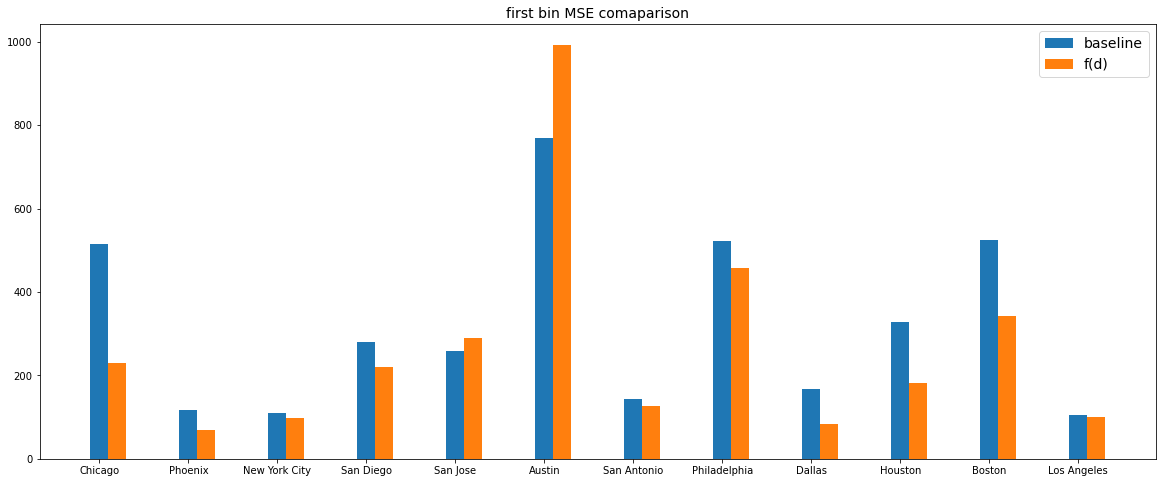

In [373]:
fig, ax = plt.subplots(figsize=(20,8))
bl = binwisemse[[col for col in binwisemse if 'bl' in col]]
ax.bar(x=range(12),height = bl.loc[0],width=0.2,label='baseline')
fd = binwisemse[[col for col in binwisemse if 'fd' in col]]
ax.bar(x=np.array(range(12))+0.2,height = fd.loc[0],width=0.2,label='f(d)')
_ = plt.xticks(range(12),[col.split('bl')[0] for col in binwisemse if 'bl' in col])
plt.title('first bin MSE comaparison',fontsize=14)
plt.legend(fontsize=14)

## bin experiement

In [123]:
city = 'Chicago.csv'
df = pd.read_csv(citiesDir+city)
bins = 20
df['bin'] = pd.qcut(df['distance'], q=bins)
df = df.sort_values(by='bin')
df['bin'] = df['bin'].astype(str)
binDict = {}
for i,j in enumerate(df.bin.unique()):
    binDict[j] = i
df['binc'] = df['bin'].apply(lambda x: binDict[x])
df['distancelog'] = np.log(df['distance'])
df['binlog'] = pd.cut(df['distancelog'], bins=bins)
df = df.sort_values(by='binlog')
df['binlog'] = df['binlog'].astype(str)
binDictlog = {}
for i,j in enumerate(df.binlog.unique()):
    binDictlog[j] = i
df['binlogc'] = df['binlog'].apply(lambda x: binDictlog[x])
df

,Unnamed: 0,origin,destination,distance,residence,jobs,flow,bin,binc,distancelog,binlog,binlogc
1648732,1648732,17031081402,17031081403,0.120030,2636,12358.0,72.0,"(0.119, 4.499]",0,-2.120015,"(-2.127, -1.79]",0
1625026,1625026,17031081403,17031081402,0.120030,4095,2397.0,11.0,"(0.119, 4.499]",0,-2.120015,"(-2.127, -1.79]",0
0,0,17031630200,17031630200,0.200000,567,909.0,18.0,"(0.119, 4.499]",0,-1.609438,"(-1.79, -1.46]",1
1056519,1056519,17031561000,17031561000,0.200000,2251,587.0,34.0,"(0.119, 4.499]",0,-1.609438,"(-1.79, -1.46]",1
1055200,1055200,17031560900,17031560900,0.200000,2271,483.0,66.0,"(0.119, 4.499]",0,-1.609438,"(-1.79, -1.46]",1
...,...,...,...,...,...,...,...,...,...,...,...,...
890368,890368,17031828402,17031801701,64.179960,1235,217.0,0.0,"(50.463, 87.827]",19,4.161691,"(4.146, 4.475]",19
1265037,1265037,17031830005,17031803901,69.950161,962,4047.0,1.0,"(50.463, 87.827]",19,4.247783,"(4.146, 4.475]",19
1392964,1392964,17031829500,17031803702,77.322886,1146,1220.0,0.0,"(50.463, 87.827]",19,4.347990,"(4.146, 4.475]",19
1350962,1350962,17031827801,17031803604,68.847987,1358,1965.0,0.0,"(50.463, 87.827]",19,4.231901,"(4.146, 4.475]",19


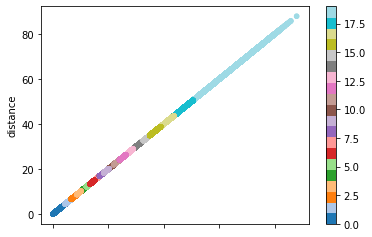

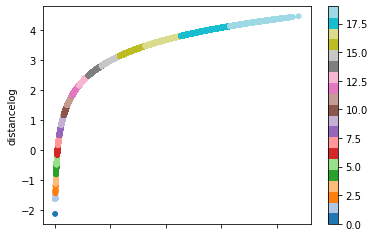

In [124]:
df.plot(kind='scatter', x='distance', y='distance', c=df['binc'], cmap='tab20')
df.plot(kind='scatter', x='distance', y='distancelog', c=df['binlogc'], cmap='tab20')
plt.show()